In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
holders_old = [ "FD:99:D9:69:5D:BC", # Badge 128
                "EC:8F:47:27:6C:DE", # Badge 129
                "E5:3B:3A:53:DF:6C", # Badge 130
                "DC:94:C8:A9:D0:B6", # Badge 131
                "CB:3C:59:5F:87:FB", # Badge 132
                "E9:0D:4A:6D:31:59"] # Badge 133

holders_new = [ "F1:4E:55:EA:ED:A4", # Badge 210
                "E8:FA:0D:3C:01:82", # Badge 211
                "C2:57:36:E6:71:6E", # Badge 212
                "D9:86:6F:AF:E8:90", # Badge 213
                "C1:96:24:5B:EB:97", # Badge 214
                "C8:2F:80:DA:26:94"] # Badge 215
dist = [2, 3, 4, 5, 6, 8, 10]
#dist = [2, 4, 6, 8, 10]

In [3]:
# @return - df_all - PANDAS DataFrame with all RSSI values by batch, holdertype, and distance
def load_all():
    
    # @param - holder - str indicating the type of holder used
    def load_holder(holder):

        # @param - dist - int indicating the distance between the receiver and transmitter during the test
        def load_dist(dist):
            raw = pd.read_csv('logs_oldvnew' + str(1+(holder=='antistatic')) + '/' + str(dist) + 'ft_CSV/000.csv')
            return raw.loc[(raw['RSSI']>-70)]              # RSSI values below about -70 are too weak to be significant

        #distances = [2, 3, 4, 5, 6, 8, 10]                # load all the distances' data in this test
        distances = dist
        df_both = pd.concat([load_dist(d) for d in distances], keys=distances, names=["FT"])

        df_new = df_both.loc[df_both['MAC'].isin(holders_new)]   # filter by badge age / batch
        df_old = df_both.loc[df_both['MAC'].isin(holders_old)]
        return pd.concat([df_new, df_old], keys=['new', 'old'], names=['BATCH'])
    
    df_reg = load_holder('regular')
    df_anti = load_holder('antistatic')
    return pd.concat([df_reg, df_anti], keys=['regular', 'antistatic'], names=['HOLDER'])

In [4]:
data = load_all()

In [5]:
data.head()

DATETIME                MAC  RSSI
HOLDER  BATCH FT                                                     
regular new   2  1   2018-03-07 16:31:52.155  D9:86:6F:AF:E8:90   -53
                 2   2018-03-07 16:31:52.178  D9:86:6F:AF:E8:90   -53
                 5   2018-03-07 16:31:52.186  C1:96:24:5B:EB:97   -50
                 6   2018-03-07 16:31:52.195  C1:96:24:5B:EB:97   -50
                 11  2018-03-07 16:31:52.451  E8:FA:0D:3C:01:82   -53

In [6]:
#mean = data['RSSI'].unstack("HOLDER").unstack("BATCH").unstack("FT").mean()
mean = data['RSSI'].groupby(["HOLDER","BATCH","FT"]).mean()

print mean, "\n"
print mean.std(level="HOLDER"), "\n"
print mean.std(level="BATCH"), "\n"
print mean.std(level="FT")

HOLDER      BATCH  FT
regular     new    2    -51.964785
                   3    -53.650392
                   4    -56.040422
                   5    -57.543660
                   6    -59.530035
                   8    -63.442297
                   10   -63.194666
            old    2    -52.670933
                   3    -54.409550
                   4    -57.144078
                   5    -58.442857
                   6    -59.076378
                   8    -63.346520
                   10   -63.633409
antistatic  new    2    -53.464144
                   3    -54.477128
                   4    -57.074492
                   5    -58.851327
                   6    -61.070576
                   8    -63.613528
                   10   -65.088805
            old    2    -53.429116
                   3    -54.687512
                   4    -57.593800
                   5    -58.109880
                   6    -59.068021
                   8    -63.024500
                   10   -65.13139

In [7]:
mean = data.loc["regular"].groupby("MAC").mean()
mean

,RSSI
MAC,
C1:96:24:5B:EB:97,-54.423303
C2:57:36:E6:71:6E,-58.505115
C8:2F:80:DA:26:94,-59.001480
CB:3C:59:5F:87:FB,-57.003403
D9:86:6F:AF:E8:90,-59.377301
DC:94:C8:A9:D0:B6,-60.027518
E5:3B:3A:53:DF:6C,-57.687937
E8:FA:0D:3C:01:82,-57.602349
E9:0D:4A:6D:31:59,-58.033591


I want to see the differene in distribution (mean? std?) for anti static vs. regular. 
so a boxplot... but a boxplot of what?

In [8]:
def comb_fields(df):
    df['combined_batch'] = df['FT'].astype(str).apply(lambda x: x.zfill(2)) + '_' + df['BATCH']
    df['combined_holder'] = df['FT'].astype(str).apply(lambda x: x.zfill(2)) + '_' + df['HOLDER']
    return df

In [9]:
rssi_data = data['RSSI'].reset_index()
rssi_data = comb_fields(rssi_data)

In [10]:
def plot_two_violin(df):
    # try this? https://stackoverflow.com/questions/47409086/how-to-plot-two-violin-plot-series-on-the-same-graph-using-seaborn
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey=True)

    df.sort_values(by=['combined_batch'], inplace=True)
    ax = sns.violinplot(ax=axes[0], x="combined_batch", y="RSSI", data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    df.sort_values(by=['combined_holder'], inplace=True)
    ax = sns.violinplot(ax=axes[1], x="combined_holder", y="RSSI", data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

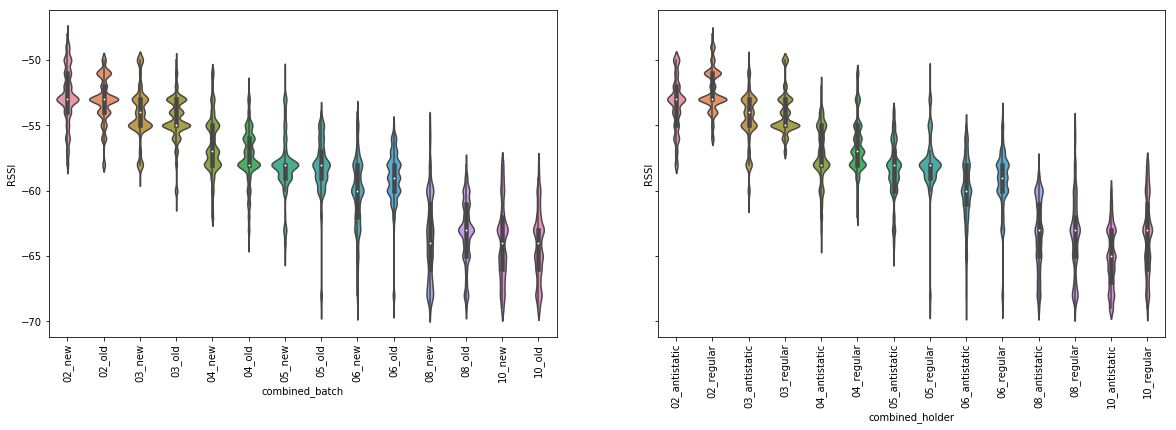

In [11]:
plot_two_violin(rssi_data)

## ROLLING MEAN

In [12]:
df = data.reset_index()
df = df.sort_values(by=['DATETIME'])
df.set_index('DATETIME', inplace=True)

rolling_mean = df.groupby(['MAC','HOLDER', 'BATCH', 'FT'])[['RSSI']] \
        .rolling(window=5) \
        .mean().dropna()

rolling_mean.head(5)

RSSI
MAC               HOLDER     BATCH FT DATETIME                     
C1:96:24:5B:EB:97 antistatic new   2  2018-03-16 16:37:13.526 -50.8
                                      2018-03-16 16:37:13.526 -50.4
                                      2018-03-16 16:37:14.787 -50.0
                                      2018-03-16 16:37:14.789 -50.0
                                      2018-03-16 16:37:15.396 -50.4

In [13]:
rolling_mean_rssi_data = rolling_mean['RSSI'].reset_index()
#rolling_mean_rssi_data['combined_batch'] = rolling_mean_rssi_data['FT'].astype(str).apply(lambda x: x.zfill(2)) + rolling_mean_rssi_data['BATCH']
#rolling_mean_rssi_data['combined_holder'] = rolling_mean_rssi_data['FT'].astype(str).apply(lambda x: x.zfill(2)) + rolling_mean_rssi_data['HOLDER']
rolling_mean_rssi_data = comb_fields(rolling_mean_rssi_data)

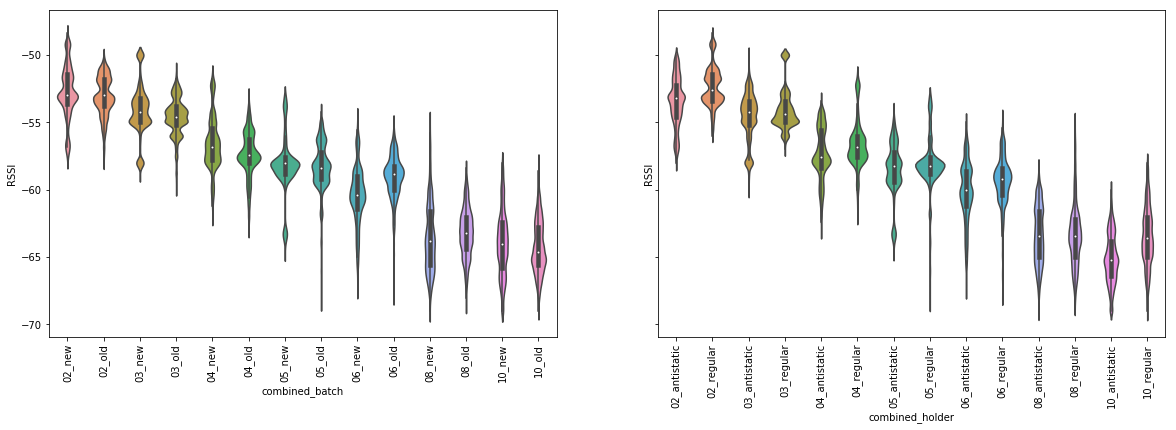

In [14]:
plot_two_violin(rolling_mean_rssi_data)

## ROLLING MAX

In [15]:
df = data.reset_index()
df = df.sort_values(by=['DATETIME'])
df.set_index('DATETIME', inplace=True)

rolling_max = df.groupby(['MAC','HOLDER', 'BATCH', 'FT'])[['RSSI']] \
        .rolling(window=5) \
        .max().dropna()

In [16]:
rolling_max_rssi_data = rolling_max['RSSI'].reset_index()
rolling_max_rssi_data = comb_fields(rolling_max_rssi_data)

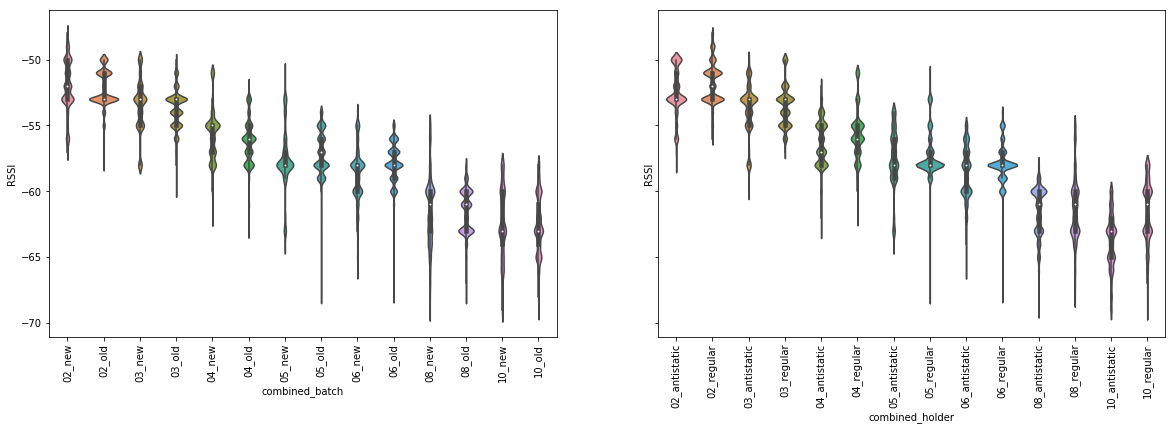

In [17]:
plot_two_violin(rolling_max_rssi_data)

# Look at individual badges

## individual rolling means

In [18]:
def plot_one_violin(df, holder, antistatic=False):
    if ~antistatic:
        df = df[df.HOLDER == 'regular'].copy().reset_index()
    df.sort_values(by=['combined_holder'], inplace=True)
    ax = sns.violinplot(x="combined_holder", y="RSSI", data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(holder)
    plt.show()

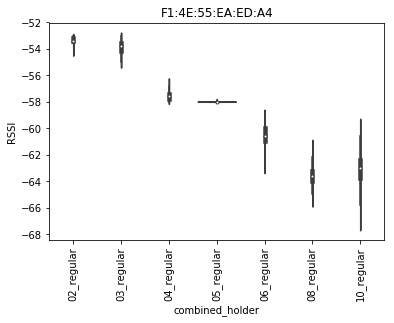

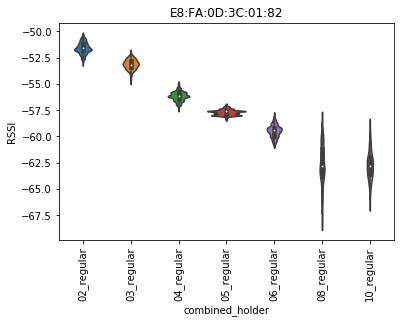

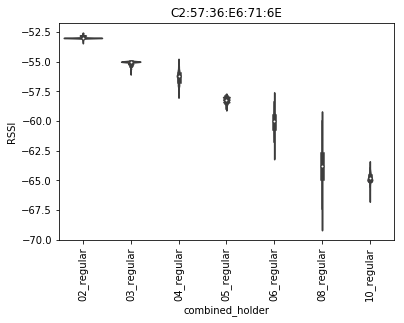

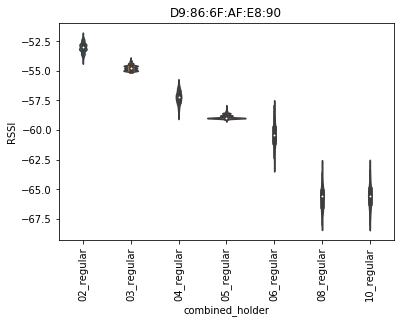

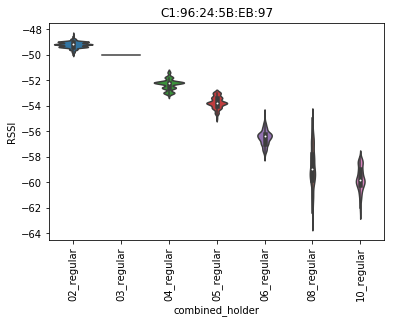

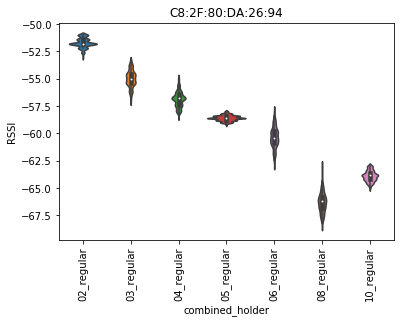

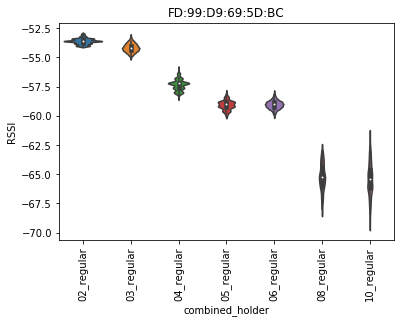

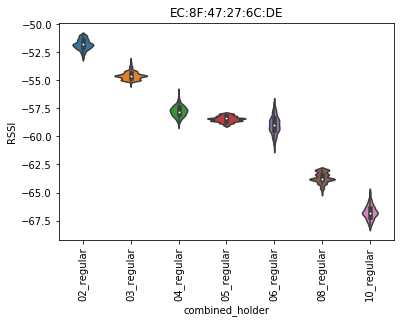

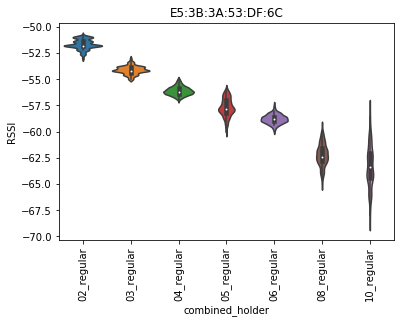

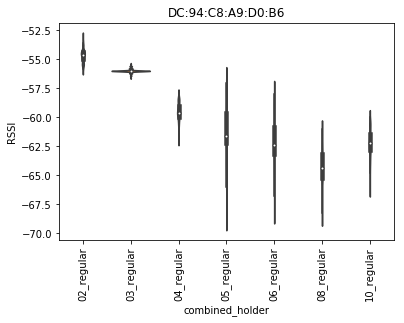

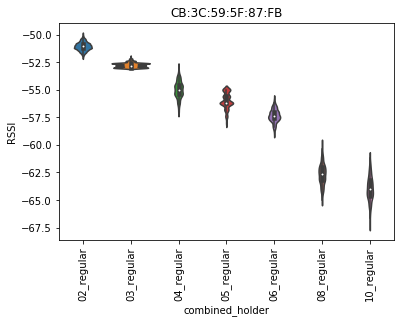

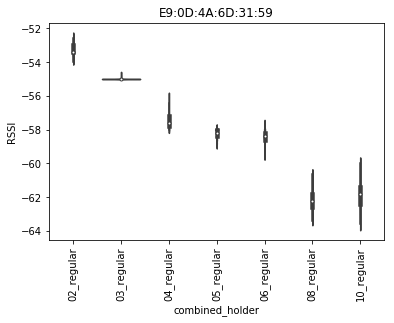

In [19]:
both = holders_new + holders_old
for holder in both:
    b = rolling_mean_rssi_data.query('MAC == "'+ holder +'"').copy().reset_index()
    plot_one_violin(b, holder)

## individual rolling maxes

F1:4E:55:EA:ED:A4 11376


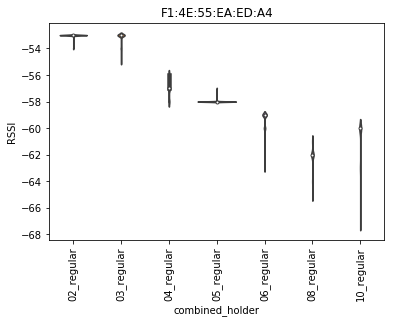

E8:FA:0D:3C:01:82 11784


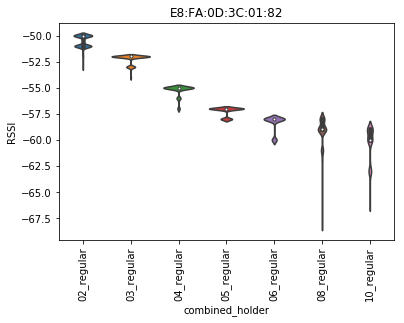

C2:57:36:E6:71:6E 11193


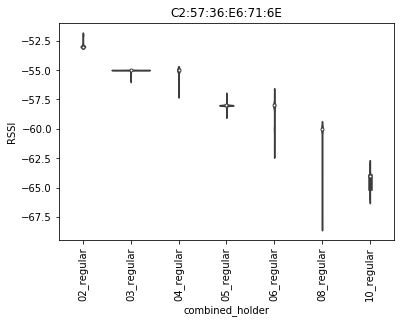

D9:86:6F:AF:E8:90 11359


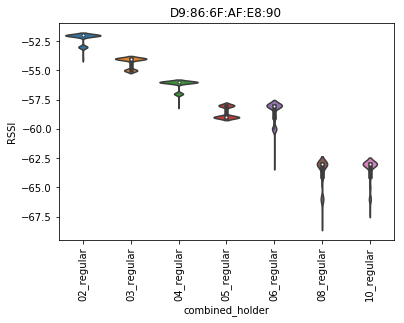

C1:96:24:5B:EB:97 11643


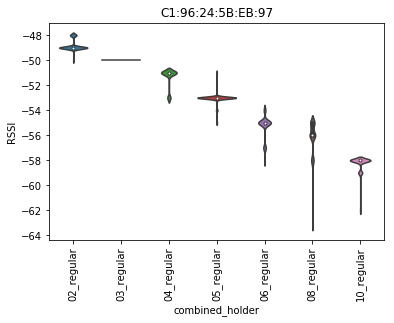

C8:2F:80:DA:26:94 11790


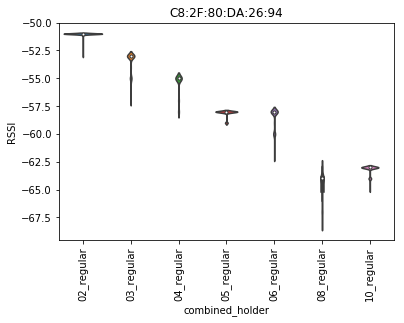

FD:99:D9:69:5D:BC 11000


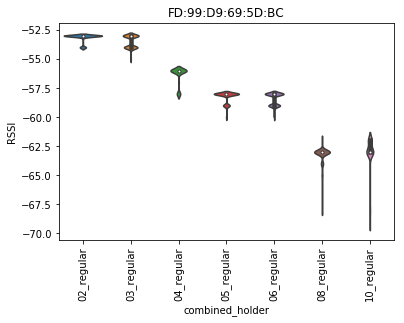

EC:8F:47:27:6C:DE 11110


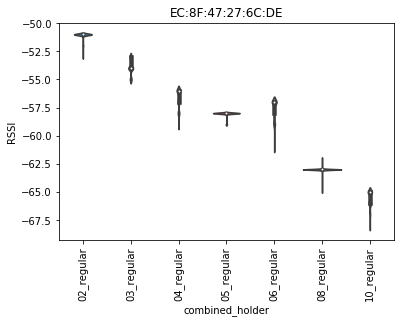

E5:3B:3A:53:DF:6C 11546


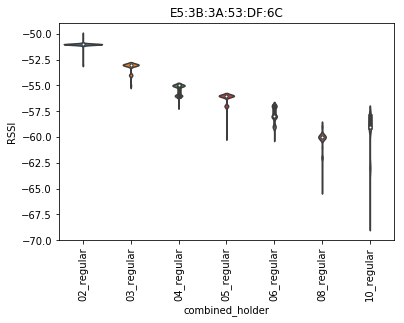

DC:94:C8:A9:D0:B6 11240


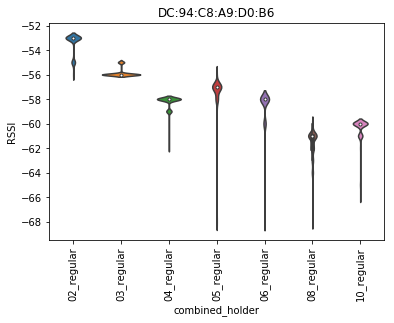

CB:3C:59:5F:87:FB 11997


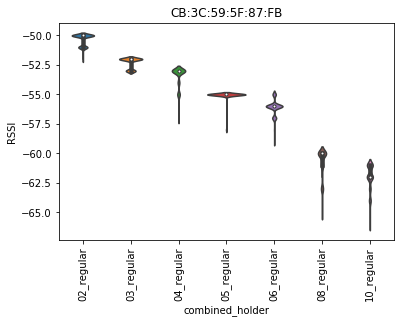

E9:0D:4A:6D:31:59 11395


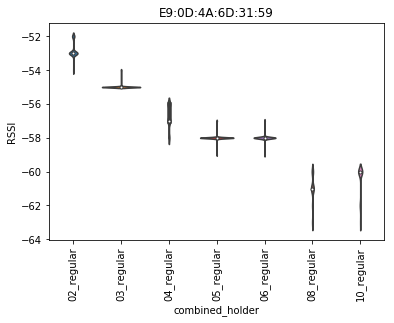

In [20]:
both = holders_new + holders_old
for holder in both:
    b = rolling_max_rssi_data.query('MAC == "'+ holder +'"').copy().reset_index()
    plot_one_violin(b, holder)